# Vehicle detection

In [125]:
# data processing
# import importlib
# importlib.reload(helper)
import helper

# logging
import time

# manipulate directories and files
import os
import glob

# plotting
import matplotlib.pyplot as plt

# loading image
import matplotlib.image as mpimg

# math
import numpy as np

# hog features
from skimage.feature import hog

# OpenCV
import cv2

# normalization
from sklearn.preprocessing import StandardScaler

# classifier & dataset splitting
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [79]:
output_images_dir = 'output_images/'

## Data exploration


In order to train a classifier, we will use a dataset comprised of images taken from the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train the classifier.

In [80]:
dataset_dir = "dataset"

helper.download_extract('vehicle', dataset_dir)
helper.download_extract('non-vehicle', dataset_dir)

Found vehicle Data
Found non-vehicle Data


In [81]:
# cars_path = os.path.join(dataset_dir, 'vehicles/**/*.png')

car_path = dataset_dir + "/vehicles/**/*.png"
# car_path = "examples/*.png"
cars_images = glob.glob(car_path, recursive=True)
cars = []

# print(len(cars_images))
# print(cars_images)
for image in cars_images:
    cars.append(image)

# notcars_path = os.path.join(dataset_dir, 'non-vehicles/**/*.png')
notcars_path = dataset_dir + "/non-vehicles/**/*.png"
# print(notcars_path)
notcars_images = glob.glob(notcars_path, recursive=True)
notcars = []

for image in notcars_images:
    notcars.append(image)
# print(len(notcars))

In [82]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

The dataset contains 8792 cars and 8968 non-cars
of size:  (64, 64, 3)  and data type: float32


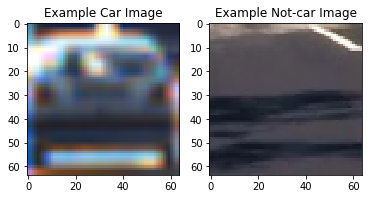

In [83]:
data_info = data_look(cars, notcars)

print('The dataset contains', 
      data_info["n_cars"], 'cars and', 
      data_info["n_notcars"], 'non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images# READ IN CAR / NOT-CAR IMAGES


car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
filename = output_images_dir + "car_notcar_example.png"
plt.savefig(filename)
plt.show()


## Features extraction

In [84]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[ind])

### Histograms of colors

In [113]:
def color_hist_extended(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers

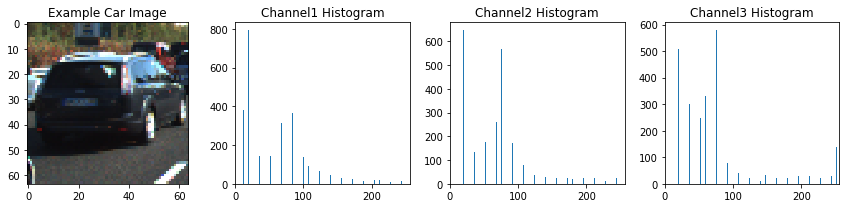

In [114]:
# rescale the image values from 0-1 to 0-255
img_scale = np.uint8(image * 255)
feature_vec, ch1h, ch2h, ch3h, bincen = color_hist_extended(img_scale, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if ch1h is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Example Car Image')
    plt.subplot(142)
    plt.bar(bincen, ch1h[0])
    plt.xlim(0, 256)
    plt.title('Channel1 Histogram')
    plt.subplot(143)
    plt.bar(bincen, ch2h[0])
    plt.xlim(0, 256)
    plt.title('Channel2 Histogram')
    plt.subplot(144)
    plt.bar(bincen, ch3h[0])
    plt.xlim(0, 256)
    plt.title('Channel3 Histogram')
    fig.tight_layout()
    filename = output_images_dir + "histogram_colors.png"
    plt.savefig(filename)
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

### Spatial binning of colors

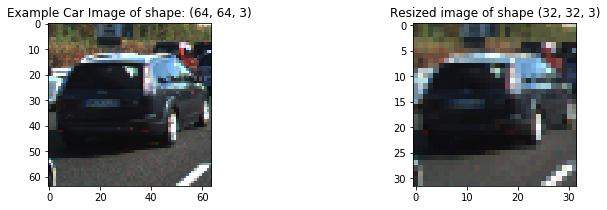

In [87]:
small_img = cv2.resize(image, (32, 32))
# Plot the examples
fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(image)
title = 'Example Car Image of shape: {}'.format(image.shape)
plt.title(title)
plt.subplot(122)
plt.imshow(small_img)
title = "Resized image of shape {}".format(small_img.shape)
plt.title(title)
filename = output_images_dir + "resized_image.png"
plt.savefig(filename)
plt.show()

While it could be cumbersome to include three color channels of a full resolution image, we can perform spatial binning on an image and still retain enough information to help in finding vehicles.

As we can see in the example above, even going all the way down to 32 x 32 pixel resolution, the car itself is still clearly identifiable by eye, and this means that the relevant features are still preserved at this resolution.

In [88]:
def bin_spatial(img, size=(32, 32)):
    """
    Compute binned color features  
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

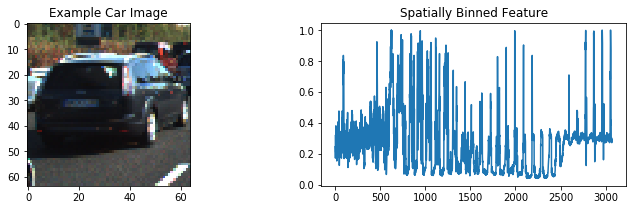

In [89]:
image_cspace = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
feature_vec = bin_spatial(image, size=(32, 32))

fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(image)
plt.title("Example Car Image")
plt.subplot(122)
plt.plot(feature_vec)
plt.title("Spatially Binned Feature")
filename = output_images_dir + "spatially_binned_feature.png"
plt.savefig(filename)
plt.show()

### HOG features

In [90]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Extract HOG features and ability to vizualiza the result
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return features

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


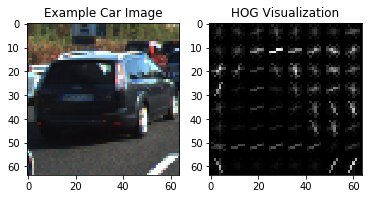

In [91]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
filename = output_images_dir + "hog_visualization.png"
plt.savefig(filename)
plt.show()

### Combine and normalize features

Extract features from a bunch of images using a combination of HOG, spatial binning of features and the histograms of pixel intensity (color histograms).

In [115]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [116]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [117]:
# color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [118]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/virt/anaconda3/envs/autonomous-car/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


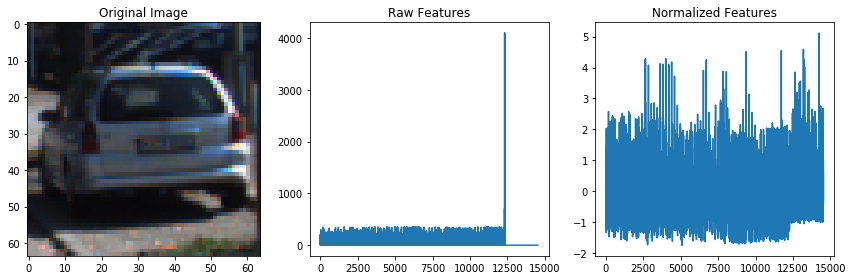

In [119]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    filename = output_images_dir + "normalized_features.png"
    plt.savefig(filename)
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

### Train a classifier

In [127]:
# define the label vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    ',pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 8 ,pixels per cell and 2 cells per block
Feature vector length: 14540


In [ ]:
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print("{} seconds to train SVC..".format(round(t2 - t, 2)))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
# Check the prediction time for a single sample
t=time.time()